In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


In [2]:
def load_datasets(year):
    data = pd.read_pickle(f"./data_{year}.pkl")
    # market cap as of the year before
    mktcap = pd.read_pickle(f"./mktcap_{year}.pkl")
    data = data.set_index("date")
    # ensure return data is numeric
    data["RET"] = pd.to_numeric(data["RET"], errors='coerce')
    return data, mktcap

def filter_by_mktcap(mktcap, cutoff):
    # extract the tickers with market cap larger than the cutoff 
    # in the paper the cutoff is set to 1 billion
    # this is not really a good method to run over several years 
    # since more and more companies will satisfy this criteria
    # TODO: improve by using a top x percentile?
    # for now set to 10 billion which gives a universe of around 200-500 stocks between 2008-2019  
    large_cap = mktcap[mktcap["mkvalt"]>mktcap_cutoff]
    large_cap_tickers = large_cap.tic.unique()
    return large_cap_tickers

# the expected_size and threshold parameters define an expectation around the size of returns samples 
# to avoid dealing with incomplete price data/etc
def calculate_daily_returns(data, tickers, expected_size=252, threshold=20):
    returns = pd.DataFrame()
    for ticker in tickers:
        stock = data[data["TICKER"]==ticker]
        if not stock.empty:
            stock = stock[~stock.index.duplicated(keep='first')] # remove duplicates for a date
            stock = stock.fillna(0) #if returns are missing just set to zero
            rows = len(stock.index)
            if rows >= expected_size - threshold and rows <= expected_size + threshold:
                returns = pd.concat([returns, stock["RET"].rename(ticker)], axis=1, join='outer')
    return returns.fillna(0)

def calculate_pca_factors(returns, pca_components):
    # standardize the return
    mean = returns.mean(axis = 0)
    std = returns.std(axis = 0)
    std_ret = (returns - mean)/std
    
    #PCA process
    pca = PCA(n_components = pca_components)
    pca.fit(std_ret)
    eigen_portfolios = pd.DataFrame(pca.components_)
    eigen_portfolios.columns = std.index
    eigen_portfolios = eigen_portfolios/std
    factor_returns = pd.DataFrame(np.dot(returns, eigen_portfolios.transpose()),index = returns.index)
    return pca, eigen_portfolios, factor_returns

def plot_variance_explained(pca):
    x = np.arange(len(pca.components_))
    cumulative = pca.explained_variance_ratio_.cumsum()

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('PCA Component')
    ax1.set_ylabel('% variance explained')
    ax1.bar(x, pca.explained_variance_ratio_)
    ax2 = ax1.twinx()
    ax2.set_ylabel('cumulative variance explained')
    ax2.plot(x, cumulative, color='red')
    fig.tight_layout() 
    plt.show()
    print("% variance explained: ")
    print(pca.explained_variance_ratio_.round(3))
    print("cumulative % variance explained: ")
    print(cumulative.round(3))
    
def calculate_residuals(stock_returns, factor_returns, num_components):
    residuals = pd.DataFrame(columns = stock_returns.columns, index = stock_returns.index)
    betas = pd.DataFrame(columns = stock_returns.columns)
    ols = LinearRegression()
    for ticker in stock_returns.columns:
        ols.fit(factor_returns.iloc[:, 0:num_components-1], stock_returns[ticker])
        fitted_returns = ols.intercept_ + np.dot(factor_returns.iloc[:, 0:num_components-1], ols.coef_)
        residuals[ticker] = stock_returns[ticker] - fitted_returns
        betas[ticker] = ols.coef_
    return residuals, betas


#reference: 
#https://commoditymodels.files.wordpress.com/2010/02/
#estimating-the-parameters-of-a-mean-reverting-ornstein-uhlenbeck-process1.pdf
def calculate_s_score(residuals, mean_reversion_speed_thresh):
    m = pd.Series()
    sigma_eq = pd.Series()
    for ticker in residuals.columns:
        stock_res = residuals[ticker]
        x_k = stock_res.cumsum()
        x_lag = x_k.shift(1)
        x_lag[0] = 0
        
        #run OLS regression to find b ==> kappa
        ols = LinearRegression(fit_intercept=True)
        ols.fit(x_lag.values.reshape(-1,1), x_k)
        b = ols.coef_[0]
        kappa = -np.log(b)*252

        #select only the stocks with fast mean reversion i.e. speed larger than the threshold
        if kappa >= mean_reversion_speed_thresh:
            a = ols.intercept_
            m[ticker] = a/(1-b)
            residual = (x_k - ols.predict(x_lag.values.reshape(-1,1)))
            sigma_eq[ticker] = np.std(residual)*np.sqrt(1/(1-b*b) )
    m = m.dropna()
    m = m - m.mean()
    sigma_eq = sigma_eq.dropna()
    s_score = -m/sigma_eq
    return s_score

2008
Total stocks selected: 254


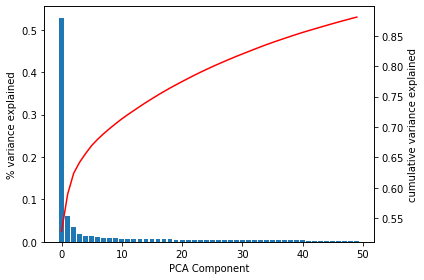

% variance explained: 
[0.529 0.061 0.034 0.018 0.014 0.013 0.01  0.009 0.008 0.008 0.008 0.007
 0.007 0.007 0.007 0.006 0.006 0.006 0.006 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004
 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003
 0.003 0.003]
cumulative % variance explained: 
[0.529 0.589 0.624 0.642 0.657 0.67  0.68  0.689 0.698 0.706 0.713 0.72
 0.727 0.734 0.74  0.746 0.753 0.758 0.764 0.769 0.775 0.78  0.785 0.79
 0.794 0.799 0.803 0.808 0.812 0.816 0.82  0.824 0.828 0.832 0.835 0.839
 0.842 0.846 0.849 0.852 0.855 0.858 0.861 0.864 0.867 0.87  0.873 0.875
 0.878 0.881]
Number of PCA components: 2, % variance explained = 0.5894784660170873
Variance explained by the first 15 components: 0.7403291029839888
2009
Total stocks selected: 181


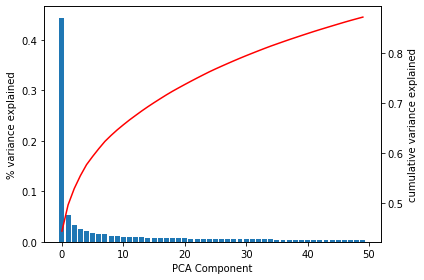

% variance explained: 
[0.444 0.052 0.032 0.026 0.022 0.017 0.015 0.015 0.012 0.011 0.01  0.01
 0.009 0.009 0.008 0.008 0.008 0.008 0.007 0.007 0.007 0.007 0.006 0.006
 0.006 0.006 0.006 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.004
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004
 0.003 0.003]
cumulative % variance explained: 
[0.444 0.497 0.529 0.555 0.577 0.593 0.609 0.624 0.635 0.646 0.657 0.666
 0.675 0.684 0.693 0.701 0.709 0.716 0.724 0.73  0.737 0.744 0.75  0.756
 0.762 0.768 0.774 0.779 0.784 0.79  0.795 0.799 0.804 0.809 0.814 0.818
 0.822 0.827 0.831 0.835 0.839 0.843 0.847 0.85  0.854 0.858 0.861 0.865
 0.868 0.872]
Number of PCA components: 4, % variance explained = 0.554963589124567
Variance explained by the first 15 components: 0.6927465154278943
2010
Total stocks selected: 219


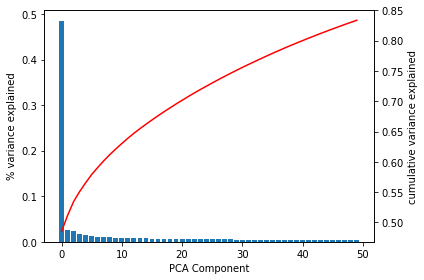

% variance explained: 
[0.485 0.026 0.023 0.017 0.015 0.014 0.012 0.011 0.01  0.009 0.009 0.009
 0.008 0.008 0.007 0.007 0.007 0.007 0.006 0.006 0.006 0.006 0.006 0.006
 0.006 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004
 0.004 0.003]
cumulative % variance explained: 
[0.485 0.512 0.534 0.551 0.566 0.579 0.591 0.602 0.612 0.621 0.63  0.639
 0.647 0.655 0.662 0.669 0.676 0.683 0.689 0.695 0.702 0.708 0.714 0.719
 0.725 0.73  0.736 0.741 0.746 0.751 0.756 0.761 0.765 0.77  0.775 0.779
 0.783 0.788 0.792 0.796 0.8   0.804 0.808 0.812 0.816 0.82  0.823 0.827
 0.83  0.834]
Number of PCA components: 4, % variance explained = 0.5509973143897081
Variance explained by the first 15 components: 0.6620551242440655
2011
Total stocks selected: 270


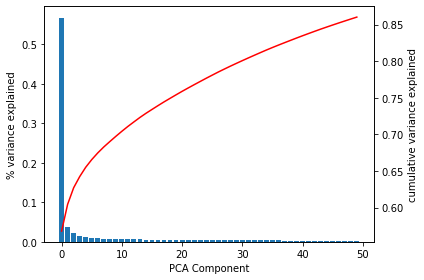

% variance explained: 
[0.568 0.037 0.023 0.015 0.013 0.01  0.009 0.008 0.007 0.007 0.007 0.007
 0.006 0.006 0.006 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.004 0.004
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.003
 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003
 0.003 0.003]
cumulative % variance explained: 
[0.568 0.605 0.627 0.642 0.655 0.666 0.675 0.683 0.69  0.697 0.704 0.711
 0.717 0.723 0.729 0.734 0.739 0.744 0.749 0.754 0.759 0.763 0.768 0.772
 0.777 0.781 0.785 0.789 0.793 0.797 0.801 0.804 0.808 0.812 0.815 0.819
 0.822 0.825 0.828 0.832 0.835 0.838 0.841 0.844 0.847 0.849 0.852 0.855
 0.857 0.86 ]
Number of PCA components: 2, % variance explained = 0.604519210982534
Variance explained by the first 15 components: 0.728740604765935
2012
Total stocks selected: 269


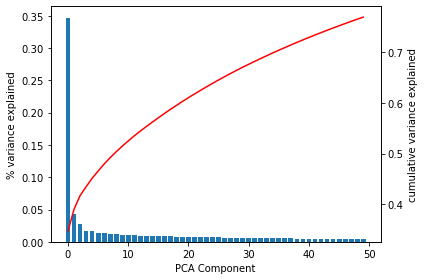

% variance explained: 
[0.347 0.043 0.027 0.017 0.017 0.014 0.014 0.013 0.012 0.011 0.01  0.01
 0.009 0.009 0.009 0.009 0.008 0.008 0.008 0.008 0.008 0.007 0.007 0.007
 0.007 0.007 0.007 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.004 0.004 0.004
 0.004 0.004]
cumulative % variance explained: 
[0.347 0.39  0.417 0.435 0.451 0.466 0.48  0.492 0.504 0.515 0.525 0.535
 0.545 0.554 0.562 0.571 0.579 0.588 0.595 0.603 0.611 0.618 0.625 0.632
 0.639 0.646 0.652 0.658 0.665 0.671 0.677 0.682 0.688 0.693 0.699 0.704
 0.709 0.715 0.72  0.725 0.73  0.734 0.739 0.744 0.748 0.752 0.757 0.761
 0.765 0.77 ]
Number of PCA components: 14, % variance explained = 0.5535348869929446
Variance explained by the first 15 components: 0.5622705831646405
2013
Total stocks selected: 302


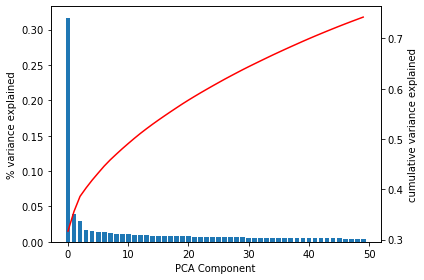

% variance explained: 
[0.317 0.039 0.03  0.017 0.015 0.014 0.014 0.012 0.011 0.011 0.01  0.01
 0.01  0.009 0.009 0.009 0.008 0.008 0.008 0.008 0.008 0.007 0.007 0.007
 0.007 0.007 0.007 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006
 0.006 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.004 0.004]
cumulative % variance explained: 
[0.317 0.356 0.386 0.403 0.418 0.432 0.446 0.459 0.47  0.481 0.491 0.501
 0.511 0.52  0.529 0.538 0.546 0.554 0.562 0.57  0.577 0.585 0.592 0.599
 0.606 0.612 0.619 0.625 0.632 0.638 0.644 0.65  0.656 0.661 0.667 0.673
 0.678 0.684 0.689 0.694 0.7   0.705 0.71  0.715 0.719 0.724 0.729 0.733
 0.738 0.742]
Number of PCA components: 18, % variance explained = 0.5540745525409307
Variance explained by the first 15 components: 0.5291334649847924
2014
Total stocks selected: 374


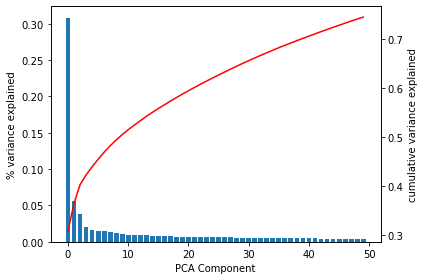

% variance explained: 
[0.309 0.056 0.038 0.02  0.016 0.015 0.015 0.013 0.012 0.011 0.01  0.009
 0.009 0.009 0.008 0.008 0.008 0.008 0.007 0.007 0.007 0.007 0.007 0.006
 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.004 0.004 0.004 0.004 0.004 0.004
 0.004 0.004]
cumulative % variance explained: 
[0.309 0.365 0.403 0.423 0.439 0.455 0.469 0.482 0.494 0.505 0.515 0.524
 0.533 0.542 0.55  0.558 0.566 0.573 0.58  0.588 0.594 0.601 0.608 0.614
 0.62  0.626 0.632 0.638 0.644 0.65  0.656 0.661 0.666 0.672 0.677 0.682
 0.687 0.692 0.696 0.701 0.706 0.71  0.715 0.719 0.723 0.728 0.732 0.736
 0.74  0.744]
Number of PCA components: 15, % variance explained = 0.5503179098478295
Variance explained by the first 15 components: 0.5503179098478295
2015
Total stocks selected: 406


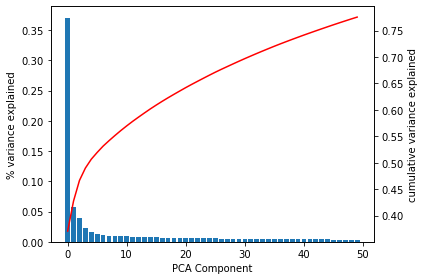

% variance explained: 
[0.371 0.057 0.039 0.023 0.017 0.013 0.012 0.01  0.01  0.009 0.009 0.009
 0.008 0.008 0.008 0.007 0.007 0.007 0.007 0.006 0.006 0.006 0.006 0.006
 0.006 0.006 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004
 0.004 0.004]
cumulative % variance explained: 
[0.371 0.428 0.467 0.49  0.507 0.52  0.531 0.542 0.551 0.561 0.57  0.578
 0.586 0.594 0.602 0.609 0.616 0.623 0.629 0.636 0.642 0.648 0.654 0.66
 0.666 0.671 0.677 0.682 0.687 0.692 0.697 0.702 0.707 0.711 0.716 0.72
 0.725 0.729 0.733 0.737 0.742 0.746 0.749 0.753 0.757 0.761 0.765 0.768
 0.772 0.775]
Number of PCA components: 9, % variance explained = 0.551487074781873
Variance explained by the first 15 components: 0.6018816640804708
2016
Total stocks selected: 374


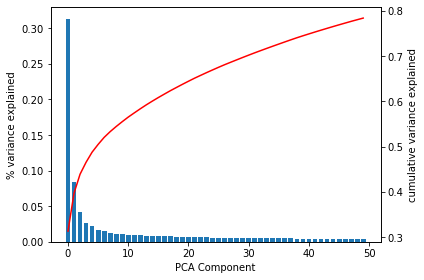

% variance explained: 
[0.313 0.084 0.042 0.026 0.022 0.017 0.016 0.013 0.011 0.011 0.01  0.009
 0.009 0.009 0.008 0.008 0.008 0.008 0.007 0.007 0.007 0.007 0.006 0.006
 0.006 0.006 0.006 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004
 0.004 0.004]
cumulative % variance explained: 
[0.313 0.397 0.439 0.465 0.488 0.505 0.52  0.533 0.544 0.555 0.565 0.574
 0.583 0.592 0.6   0.608 0.616 0.623 0.63  0.637 0.644 0.651 0.657 0.663
 0.669 0.675 0.681 0.686 0.691 0.697 0.702 0.707 0.712 0.717 0.722 0.726
 0.731 0.736 0.74  0.744 0.749 0.753 0.757 0.761 0.765 0.769 0.773 0.776
 0.78  0.784]
Number of PCA components: 10, % variance explained = 0.5548958602261529
Variance explained by the first 15 components: 0.6002940182255726
2017
Total stocks selected: 410


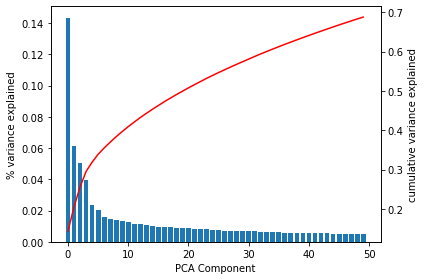

% variance explained: 
[0.144 0.062 0.05  0.04  0.024 0.02  0.016 0.015 0.014 0.013 0.012 0.012
 0.011 0.011 0.01  0.01  0.01  0.009 0.009 0.009 0.009 0.008 0.008 0.008
 0.008 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.006 0.006 0.006 0.006
 0.006 0.006 0.006 0.006 0.006 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005]
cumulative % variance explained: 
[0.144 0.205 0.256 0.295 0.319 0.339 0.355 0.37  0.384 0.397 0.409 0.421
 0.432 0.443 0.453 0.463 0.473 0.482 0.491 0.499 0.508 0.516 0.524 0.532
 0.539 0.547 0.554 0.561 0.568 0.574 0.581 0.588 0.594 0.6   0.607 0.613
 0.619 0.624 0.63  0.636 0.641 0.647 0.652 0.657 0.663 0.668 0.673 0.678
 0.683 0.688]
Number of PCA components: 27, % variance explained = 0.5539326188200417
Variance explained by the first 15 components: 0.45322851291504757
2018
Total stocks selected: 490


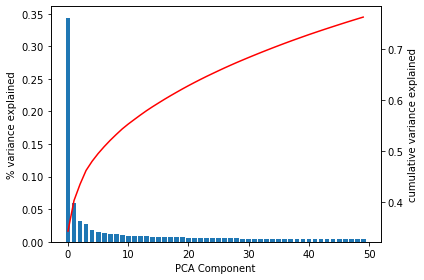

% variance explained: 
[0.344 0.06  0.032 0.027 0.018 0.015 0.013 0.012 0.011 0.011 0.01  0.009
 0.009 0.008 0.008 0.007 0.007 0.007 0.007 0.007 0.006 0.006 0.006 0.006
 0.006 0.006 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004
 0.004 0.004]
cumulative % variance explained: 
[0.344 0.404 0.435 0.462 0.48  0.495 0.509 0.521 0.533 0.544 0.553 0.562
 0.571 0.579 0.587 0.594 0.601 0.608 0.615 0.622 0.628 0.634 0.64  0.646
 0.652 0.657 0.663 0.668 0.673 0.678 0.683 0.688 0.693 0.697 0.702 0.706
 0.711 0.715 0.719 0.724 0.728 0.732 0.736 0.74  0.743 0.747 0.751 0.755
 0.758 0.762]
Number of PCA components: 11, % variance explained = 0.5530565439561805
Variance explained by the first 15 components: 0.5866104597887142
2019
Total stocks selected: 469


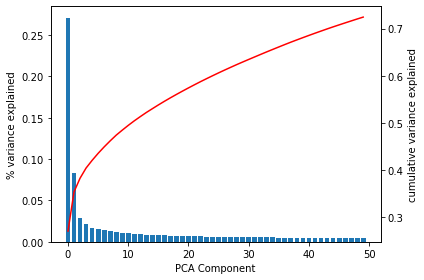

% variance explained: 
[0.271 0.083 0.029 0.022 0.016 0.015 0.014 0.013 0.012 0.011 0.01  0.01
 0.009 0.009 0.008 0.008 0.008 0.007 0.007 0.007 0.007 0.007 0.007 0.006
 0.006 0.006 0.006 0.006 0.006 0.006 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.004 0.004 0.004 0.004
 0.004 0.004]
cumulative % variance explained: 
[0.271 0.354 0.383 0.405 0.421 0.436 0.449 0.462 0.474 0.485 0.495 0.505
 0.514 0.522 0.53  0.538 0.546 0.553 0.561 0.568 0.574 0.581 0.588 0.594
 0.6   0.606 0.612 0.618 0.624 0.629 0.635 0.64  0.646 0.651 0.656 0.661
 0.666 0.671 0.676 0.681 0.686 0.69  0.695 0.699 0.704 0.708 0.712 0.716
 0.721 0.725]
Number of PCA components: 18, % variance explained = 0.5534987566562072
Variance explained by the first 15 components: 0.5304014655456168


In [3]:
mktcap_cutoff = 10000 #in millions
pca_components = 50 # max number of pca components
expl_var_thresh = 0.55 # threshold to select the number of pca components

# Note: in the Avellaneda and Lee paper, one of the methods proposed is 
# to choose the number of PCA components that explain the 55% of variance.
# This does not seem a good way to do it because PCA 1 seems to be largely dependent
# of the market behavior.
# We try to replicate the method in the paper but there should be a better way to do this?



save_data = True
years = range(2008,2020)
for yr in years:
    print(yr)
    print("===============================================================================")
    data, mktcap = load_datasets(yr)
    # select an universe and calculate its returns in this year
    tickers = filter_by_mktcap(mktcap, mktcap_cutoff)
    returns = calculate_daily_returns(data, tickers)
    print(f"Total stocks selected: {len(returns.columns)-1}")
    # calculate pca factors
    pca, eigen_portfolios, factor_returns = calculate_pca_factors(returns, pca_components)
    plot_variance_explained(pca)
    cumulative = pca.explained_variance_ratio_.cumsum()

    # choose how many PCA components are used from the explained variance threshold
    chosen_comps = list(map(lambda i: i> expl_var_thresh, cumulative )).index(True) + 1
    chosen_comps = max(chosen_comps, 2) #select at least 2 components
    print(f"Number of PCA components: {chosen_comps}, % variance explained = {cumulative[chosen_comps-1]}")

    var_15_comps = cumulative[14]
    print(f"Variance explained by the first 15 components: {var_15_comps}")

    #calculate residuals, both with the 55% variance explained method and the 15 PCA components method
    residuals_55var, betas_55var = calculate_residuals(returns, factor_returns, chosen_comps)
    residuals_15pca, betas_15pca = calculate_residuals(returns, factor_returns, 15)    

    # serialize for future use
    if save_data:
        eigen_portfolios.to_pickle(f"./eigen_{yr}.pkl")
        factor_returns.to_pickle(f"./eigen_returns_{yr}.pkl")
        residuals_55var.to_pickle(f"residuals_var_{yr}.pkl")
        betas_55var.to_pickle(f"betas_var_{yr}.pkl")
        residuals_15pca.to_pickle(f"residuals_pca_{yr}.pkl")
        betas_15pca.to_pickle(f"betas_pca_{yr}.pkl")

In [4]:
residuals = pd.read_pickle(f"./residuals_pca_2012.pkl")
scores = calculate_s_score(residuals,0)

In [5]:
scores.sort_values(ascending=False)

TRP      2.348819
PEG      2.167333
D        1.936155
JCI      1.880266
KGC      1.802611
ADBE     1.704516
CHRW     1.584151
MSI      1.567259
TWX      1.549863
PCP      1.547723
DISH     1.512418
PPG      1.498908
COST     1.495295
DOV      1.466422
F        1.432618
KR       1.405405
RCI      1.395080
SNDK     1.364594
BA       1.349588
LLY      1.344506
MCD      1.312367
BDX      1.309231
CP       1.297826
MUR      1.278127
NBL      1.263818
NLSN     1.239698
ENB      1.229566
IP       1.202503
NUE      1.190365
WYNN     1.188385
           ...   
SO      -1.184087
INTC    -1.190654
CMCSA   -1.214705
GE      -1.218330
DD      -1.252962
TJX     -1.269481
MJN     -1.294396
USB     -1.315698
EMC     -1.336203
NLY     -1.347272
AAPL    -1.377067
WFC     -1.408479
COV     -1.473056
BRCM    -1.532839
TGT     -1.533046
T       -1.542808
PCG     -1.560205
ESRX    -1.593365
SLB     -1.656098
ROST    -1.763016
APA     -1.784089
DVN     -1.812113
AGU     -1.860340
SU      -1.865925
RIG     -1

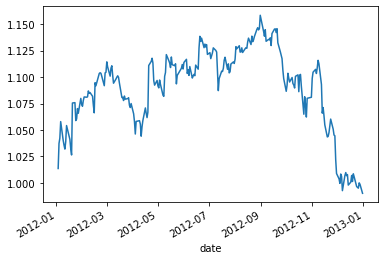

In [7]:
(1 + residuals["MSFT"]).cumprod().plot()